In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12
import os
import subprocess
# Because Collab Jupyter Notebooks are headless, we need to launch a simple
# Xserver on DISPLAY :42 to use Mayavi/VTK Rendering
xvfbcommand = "Xvfb :42 -screen 0 1280x1024x24 -auth localhost".split(" ")
subprocess.Popen(['nohup'] + xvfbcommand,
                 stdout=open('/dev/null', 'w'),
                 stderr=open('/tmp/xvfb-logfile.log', 'a'),
                 preexec_fn=os.setpgrp
                 )
os.environ["DISPLAY"] = ":42"
from mayavi import mlab
mlab.init_notebook("png")

from netCDF4 import Dataset
import numpy as np
import sys
for pap in ["/home/lahaye/Coding/"+pa for pa in ["Py3_ROMS_Modules","Python_ROMS_Modules/lahaye"]]:
    if pap not in sys.path: sys.path.append(pap)
import R_tools_fort as toolf
import R_tools as tools
import comp_zlevs as zlev

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

Notebook initialized with png backend.


In [2]:
#path_data = KRYPTON + "luckyto_his.mean.00720-01080.nc"
path_data = RUCHBA + "data_from_Irene/LUCKYTO/luckyto_diags_pv_avg.00900-01080.nc"
path_grid = KRYPTON + "lucky_corgrd.nc"

picdir = "pictures/"

what = "ke_diss_mean"

xm, ym = -32.28, 37.3
Lx, Ly = 2*2*30*1852*np.array([1,1]) # extend in m
Nz = 80 # WARNING en dure !

mean data value: -0.068273604


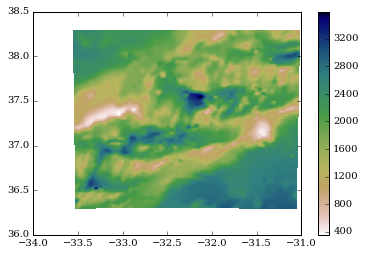

In [3]:
# load grid and data
nc = Dataset(path_grid, "r")
ncvar = nc.variables
lon = ncvar['lon_rho'][:]
lat = ncvar['lat_rho'][:]
dx = .5*(np.mean(1./ncvar['pm'][:]) + np.mean(1./ncvar['pn'][:]) )
jm, im = np.unravel_index( ((lon-xm)**2 + (lat-ym)**2).argmin(), lon.shape )
j1, j2 = jm + np.array([-1,1])*int(Lx/dx/2.)
i1, i2 = im + np.array([-1,1])*int(Ly/dx/2.)
topo = nc.variables['h'][j1:j2,i1:i2]
nc.close()
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]

Ny, Nx = topo.shape

nc = Dataset(path_data, "r")
ncvar = nc.variables
data = ncvar[what][...,j1:j2,i1:i2].squeeze()
if data.shape[0] == Nz+1:
    data = .5* (data[1:,...] + data[:-1,...])
nc.close()
lonm, latm = lon.mean(axis=0), lat.mean(axis=1)

    
print("mean data value:", data.mean())
plt.pcolormesh(lon, lat, topo, cmap='gist_earth_r')
plt.colorbar()

In [4]:
hc = 300.
Cs_r, Cs_w = zlev.get_scoord(hc, 6, 4, 80)
zr, zw = toolf.zlevs(topo.T, np.zeros(topo.T.shape), hc, Cs_r, Cs_w)
#zlev.zlev_rho(topo.T, np.zeros(topo.T.shape), hc, Cs_r)
zabr = zr + topo.T[...,None]
zabw = zw + topo.T[...,None]

if what in ["ke_diss_mean"]: # KE diss diag is volume cell integrated
    data /= -(np.diff(zw, axis=-1)*dx**2).T
    
zmin = zabr.min()
print(zmin)

mab = np.array([10, 50, 100, 100, 200, 300, 400, 500, 600, 750, 1000])
zint = mab[None,None,:] - topo.T[...,None]

ke_ab = tools.vinterp(data.T, zint, zr, zw, interp_sfc=0, interp_bot=0).T


1.5933131660255526


/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


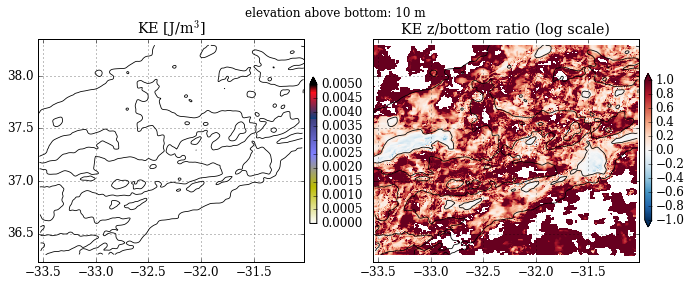

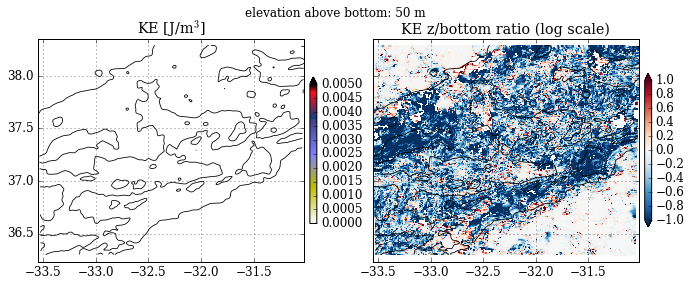

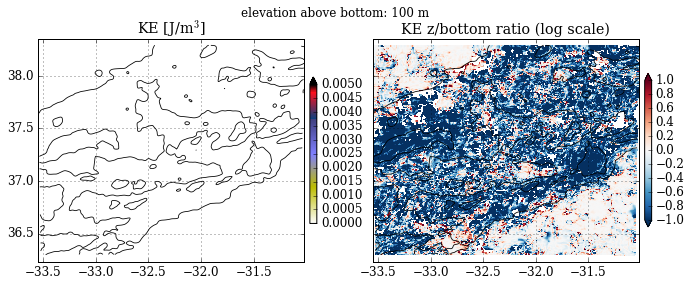

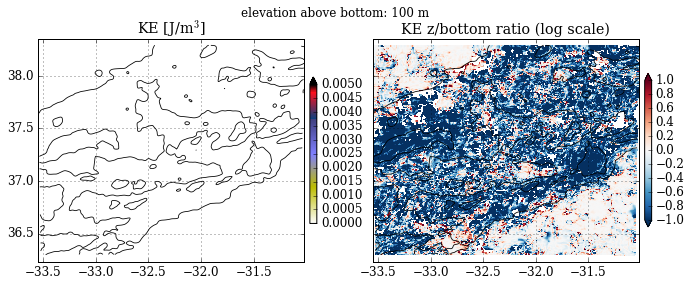

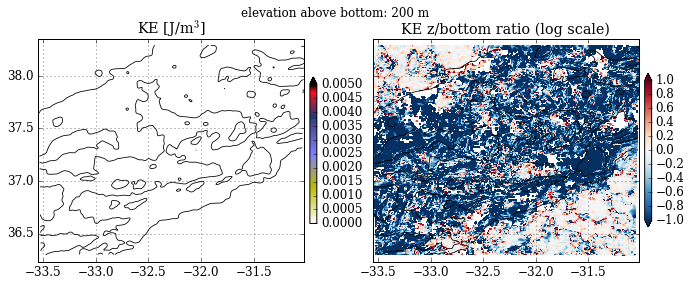

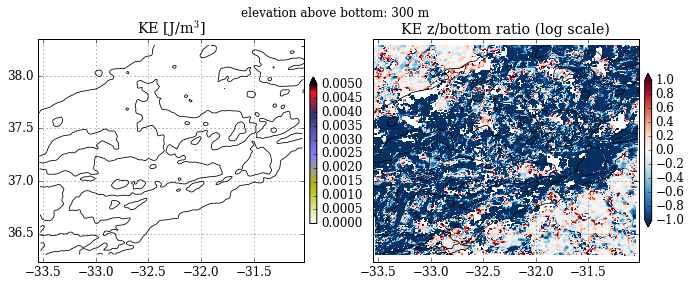

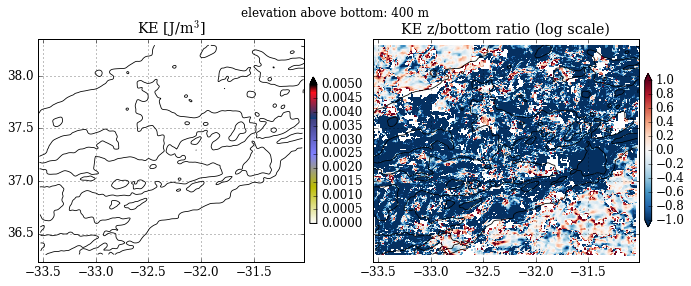

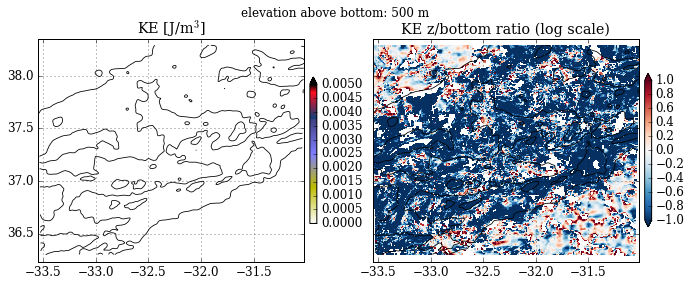

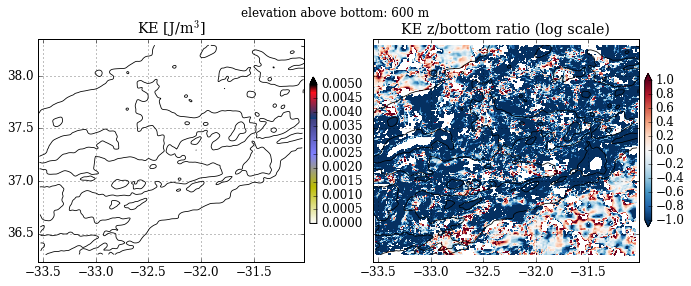

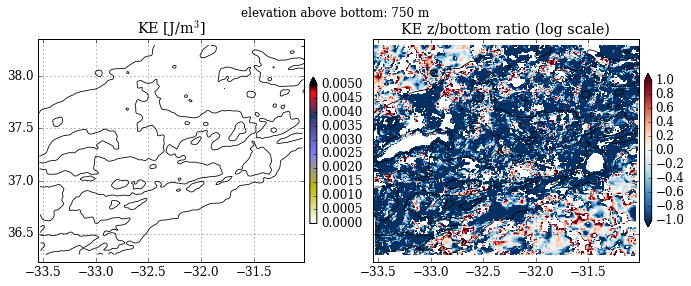

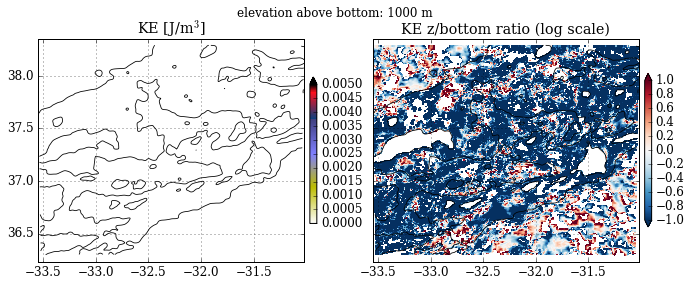

In [70]:
cmap = "RdBu_r"
vmin, vmax = -1, 1
vamp = 5e-3
vamm = 1e-4 if what == "AKv" else 0.
zlevs = [1000, 2000, 3500]
izrf = 1

for iz in range(len(mab)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,4))

    ax = axs[0]
    hpc = ax.pcolormesh(lon, lat, ke_ab[iz,:,:], cmap="gist_stern_r", vmin=vamm, vmax=vamp)
    plt.colorbar(hpc, ax=ax, extend="max", fraction=.025, pad=.02)
    hct = ax.contour(lon, lat, topo, levels=zlevs, colors="k", linewidths=0.8)
    for item in hct.collections:
        item.set_rasterized(True)

    ax = axs[1]
    hpc = ax.pcolormesh(lon, lat, np.log10(ke_ab[iz,:,:]/data[izrf,:,:]), cmap="RdBu_r", vmin=-1, vmax=1)
    plt.colorbar(hpc, ax=ax, extend="both", fraction=.025, pad=.02)
    hct = ax.contour(lon, lat, topo, levels=zlevs, colors="k", linewidths=0.8)
    for item in hct.collections:
        item.set_rasterized(True)

    for ax in axs:
        ax.set_aspect("equal")
        ax.grid(True)
        ax.set_xlim([lon.min(),lon.max()])
        ax.set_ylim([lat.min(),lat.max()])

    axs[0].set_title(r'KE [J/m$^3$]')
    axs[1].set_title(r'KE z/bottom ratio (log scale)')
    plt.suptitle(r'elevation above bottom: {:0d} m'.format(int(mab[iz])), y=1.01)

    #fig.savefig(picdir+"luckyto_KEbc_{:02d}mab.png".format(int(mab[iz])), magnification="auto", bbox_inches="tight", dpi=150)
    print(iz, end=", ")
#fig.set_tight_layout(True)

In [5]:
x2d, y2d = np.mgrid[0:Nx,0:Ny]
Nzp = 100
zplot = np.linspace(zr.min(), -100, 100)
kepl = tools.vinterp(data.T, zplot, zr, zw, interp_sfc=0, interp_bot=0)

xpl, ypl, zpl = np.mgrid[0:Nx,0:Ny,0:len(zplot)]

#mlab.figure()
#s = mlab.surf(x2d, y2d, (-topo.T-zr.min())/(-100-zr.min())*Nzp, colormap="gist_earth")
#mlab.contour3d(xpl, ypl, zpl, kepl, contours=[1e-3], transparent=True, color=(0.5,0.5,1))
#mlab.view(azimuth=60, elevation=-60, distance=200, focalpoint="auto")
#s

In [ ]:
#ia = 85*2 #55*2 #85*2
ia = 82*2 #99*2 

plane = "x"
planb = "y" if plane == "x" else "x"
ib = None #85*2
cmap = "PRGn" #"PuBuGn"

#toplot = np.log10(kepl)
toplot = kepl
vmiz, vmaz = 2*np.array([-1,1])*np.nanstd(toplot) # np.nanmean(toplot) + 5*np.array([-1,1])*np.nanstd(toplot)

mlab.init_notebook("png")
print(ia, ib, plane, planb)

fig = mlab.figure(size=(800,800))
s = mlab.surf(x2d, y2d, (-topo.T-zr.min())/(-100-zr.min())*Nzp/2, colormap="gist_earth")#color=(0.6,0.6,0.6))
#for iy in iys:
hpv = mlab.volume_slice(xpl, ypl, zpl, toplot, slice_index=ia, plane_orientation=plane+"_axes"\
                  , colormap=cmap, vmin=vmiz, vmax=vmaz, transparent=True)
mlab.colorbar(hpv)
if ib is not None:
    mlab.volume_slice(xpl, ypl, zpl, toplot, slice_index=ib, plane_orientation=planb+"_axes"\
                  , colormap=cmap, vmin=vmiz, vmax=vmaz, transparent=True)
mlab.view(azimuth=120, elevation=-50, distance=350, focalpoint="auto")

s

In [7]:
mlab.savefig('pictures/slice_LuckyHoleWall-{0}_{1}.png'.format(planb,what), magnification="auto")

In [202]:
mlab.savefig?